# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

### Idea is to try and predict geopotential 1 hr ahead
### Geopotential approximates the actual height of a pressure surface above mean sea-level. (it is integral of g from 0 to z at p=pressure)
### So in this case trying to predict height of 500hPa pressure level

### 5.625 refers to 32*64 grid points



In [1]:
import xarray as xr
import matplotlib.pyplot as plt

## Downloading the data

The data is hosted here. For this guide we will simply download the 500 hPa geopotential data (Z500).

In [4]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

--2020-09-10 17:42:44--  https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip
Resolving dataserv.ub.tum.de (dataserv.ub.tum.de)... 2001:4ca0:800::8af6:e022, 138.246.224.34
Connecting to dataserv.ub.tum.de (dataserv.ub.tum.de)|2001:4ca0:800::8af6:e022|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532774663 (1.4G) [application/zip]
Saving to: ‘geopotential_500_5.625deg.zip’

100%[====================================>] 1,532,774,663 24.1MB/s   in 61s    

2020-09-10 17:43:46 (24.1 MB/s) - ‘geopotential_500_5.625deg.zip’ saved [1532774663/1532774663]



In [5]:
!mkdir -p geopotential_500
!unzip -d geopotential_500/ geopotential_500_5.625deg.zip

Archive:  geopotential_500_5.625deg.zip
  inflating: geopotential_500/geopotential_500hPa_1979_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1980_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1981_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1982_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1983_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1984_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1985_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1986_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1987_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1988_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1989_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1990_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1991_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1992_5.625deg

## Open the data

In [2]:
z500 = xr.open_mfdataset('geopotential_500/*.nc', combine='by_coords')

In [3]:
z500

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


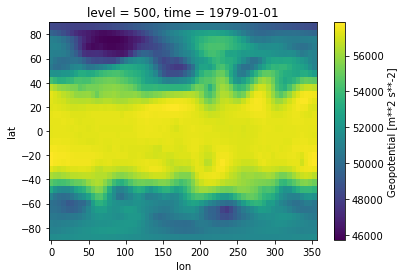

In [4]:
# Plot an example
z500.z.isel(time=0).plot();

## Create a simple climatological forecast

Remember that we are using the years 2017 and 2018 for testing/evaluation, so we are not allowed to use these years to train any data-driven model.

For more information on the climatology and persistence forecasts used in the paper check out `notebooks/1-climatology-persistence.ipynb`.

In [5]:
# To speed things up we will just take the mean for 2016
climatology = z500.sel(time=slice('2016', '2016')).mean('time').load()

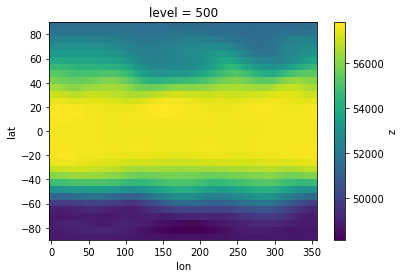

In [6]:
climatology.z.plot()

### Evaluate the climatology

Please check the paper for details on the evaluation metric. Here we will use the functions from `src/score.py`. To make sure we are always using the same targets for testing, we also implemented a function to load the test data.

In [7]:
from src.score import *

In [8]:
z500_test = load_test_data('geopotential_500/', 'z')[::12]  # Take data only every 12 hours to speed up computation on Binder

In [9]:
rmse_climatology = compute_weighted_rmse(climatology.z, z500_test).load()

In [10]:
rmse_climatology

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

So we get a climatological RMSE of 1080 m^2/s^2 which is very similar to the RMSE we get for the climatology for all training years.

## Train a neural network

Now let's train a simple convolutional neural network. We are using several functions defined in `src/train_nn.py`. You can use and modify these or write your own function for data loading etc. 

For more information on the the networks check out `notebooks/3-cnn-example.ipynb`.

In [13]:
from src.train_nn import *

In [14]:
# This limits TF memory usage on the GPU
# limit_mem()

First, we need to create the data generators for training, validation and testing. The main reason why we are using data generators instead of just loading the data as Numpy arrays is that this would require loading the same data twice since the features and targets are the same fields, just offset in time. 

In [14]:
bs = 32
lead_time = 5*24
var_dict = {'z': None}

In [15]:
# Use 2015 for training and 2016 for validation
dg_train = DataGenerator(
    z500.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    z500.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [16]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(z500.sel(time=slice('2017', '2018')).isel(time=slice(0, None, 12)), # Limiting the data for Binder
                        var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [17]:
X, y = dg_train[0]

In [18]:
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

((32, 32, 64, 1), (32, 32, 64, 1))

Now let's build a simple fully convolutional network. We are using periodic convolutions in the longitude direction. These are defined in `train_nn.py`.

In [19]:
cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)),
    PeriodicConv2D(filters=1, kernel_size=5)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
periodic_conv2d (PeriodicCon (None, 32, 64, 32)        832       
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 32, 64, 1)         801       
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [21]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [22]:
# Train a little bit ;)
cnn.fit(dg_train, epochs=1, validation_data=dg_valid)

270/270 [==============================] - 212s 784ms/step - loss: 2.2590 - val_loss: 1.0672


### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [23]:
preds = create_predictions(cnn, dg_test)

In [24]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 1340)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-02 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 51582.9 51648.28 ... 52698.355 52699.293

In [25]:
compute_weighted_rmse(preds.z, z500_test).load()

<xarray.DataArray ()>
array(1272.45428072)

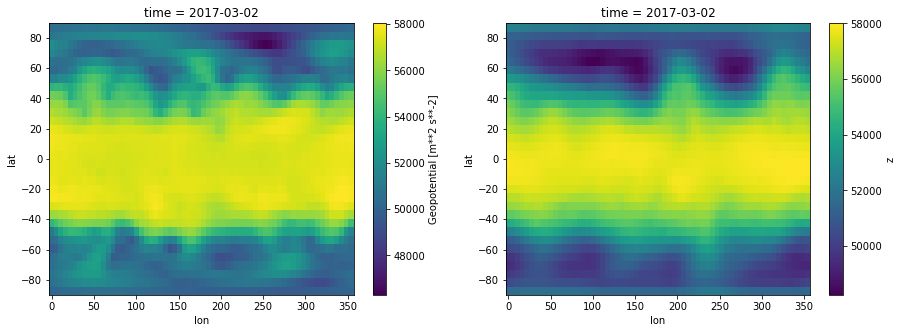

In [26]:
time = '2017-03-02T00'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
z500_test.sel(time=time).plot(ax=ax1)
preds.sel(time=time).z.plot(ax=ax2);

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.